# Solution : Prédiction de la meilleure distance obtenue avec le club de golf bois 3

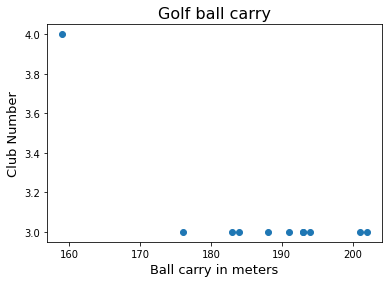

float64    3
int64      3
dtype: int64
   Portee  Vitesse de balle  Apex  Angle envol  Dispersion  \
0     188               131    26         14.8         5.3   
1     176               126    37         20.7        37.6   
2     193               134    31         16.7        25.7   
3     193               132    26         14.8         7.4   
4     183               127    34         19.3        10.9   
5     201               138    22         12.1         2.4   
6     194               133    30         16.8        18.1   
7     184               132    30         16.6        29.2   
8     191               130    29         17.1        12.6   
9     202               138    27         13.3        17.8   

   Distance au drapeau  
0                  8.4  
1                 47.4  
2                 30.1  
3                  9.2  
4                 16.9  
5                 18.9  
6                 22.1  
7                 35.7  
8                 15.2  
9                 24.5  


In [135]:
import pandas as pd
import numpy as np
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_columns = 99

golf = pd.read_csv('golf-data.csv')

stripped_commas_a = golf["Angle envol"].str.replace(",",".")
golf["Angle envol"] = stripped_commas_a.astype('float')

stripped_commas_d = golf["Dispersion"].str.replace(",",".")
golf["Dispersion"] = stripped_commas_d.astype('float')

stripped_commas_dd = golf["Distance au drapeau"].str.replace(",",".")
golf["Distance au drapeau"] = stripped_commas_dd.astype('float')

plt.scatter(golf["Portee"],golf["Club"])
plt.title("Golf ball carry", fontsize=16)
plt.xlabel("Ball carry in meters", fontsize=13)
plt.ylabel("Club Number", fontsize=13)
#plt.yticks(np.arange(min(y), max(y)+1, 1.0))
plt.show()

#numéro du club de golf
club_golf_number = 3
golf = golf[golf["Club"] == club_golf_number]

#filter_club = golf["Club"] == club_golf_number
#golf.where(filter_club, inplace = True)

#On ne prend pas en compte si la donnée de Portee est absente
golf.dropna(subset=['Portee'], inplace = True)

del golf["Club"]
del golf["Distance Totale"]

print(golf.dtypes.value_counts())
print(golf.head(25))


In [95]:
# Normaliser toutes les colonnes de sorte que les valeurs soient comprises entre 0 et 1 sauf pour la colonne cible.
portee_col = golf['Portee']
golf = (golf - golf.min())/(golf.max() - golf.min())
golf['Portee'] = portee_col

golf.head(20)

,Portee,Vitesse de balle,Apex,Angle envol,Dispersion,Distance au drapeau
0,188,0.416667,0.266667,0.313953,0.082386,0.000000
1,176,0.000000,1.000000,1.000000,1.000000,1.000000
2,193,0.666667,0.600000,0.534884,0.661932,0.556410
3,193,0.500000,0.266667,0.313953,0.142045,0.020513
4,183,0.083333,0.800000,0.837209,0.241477,0.217949
5,201,1.000000,0.000000,0.000000,0.000000,0.269231
6,194,0.583333,0.533333,0.546512,0.446023,0.351282
7,184,0.500000,0.533333,0.523256,0.761364,0.700000
8,191,0.333333,0.466667,0.581395,0.289773,0.174359
9,202,1.000000,0.333333,0.139535,0.437500,0.412821


## Modèle univarié

In [96]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def knn_train_test(k, train_col, target_col, df):
    knn = KNeighborsRegressor(n_neighbors=k)
    np.random.seed(0)
    
    # Randomiser l'ordre des lignes du DataFrame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    # Diviser le nombre de lignes de moitié.
    last_train_row = int(len(rand_df) / 2)

    
    # Sélectionner la première moitié en set de training.
    # Sélectionner la seconde moitié en set de test.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    #print(train_df)
    #print("-------------------")
    #print(test_df)

    # Ajuster un modèle KNN utilisant la valeur par défaut k.
    knn.fit(train_df[[train_col]], train_df[target_col])

    # faire des prédictions en utilisant ce modèle.
    predicted_labels = knn.predict(test_df[[train_col]])
    
    # Calculer et retourner la valeur RMSE.
    mse = mean_squared_error(test_df[target_col], predicted_labels)
    rmse = np.sqrt(mse)
    
    return rmse

In [97]:
rmse_results = {}
train_cols = golf.columns.drop('Portee')

#train_cols.head()
# Pour chaque colonne (excepté 'Portee'), entrainer un modèle et retourner la valeur RMSE.
# et ajouter cette valeur au dictionnaire 'rmse_results'.
k = 3

for col in train_cols:
    rmse_val = knn_train_test(k ,col, 'Portee', golf)
    rmse_results[col] = rmse_val

# Créer un objet Series depuis le dictionnaire
# ainsi nous pouvons facilement voir les résultats, les trier, etc…
rmse_results_series = pd.Series(rmse_results)
rmse_results_series.sort_values()

Vitesse de balle       3.895867
Angle envol            5.316641
Dispersion             5.331250
Distance au drapeau    5.331250
Apex                   6.656659
dtype: float64

In [98]:
def knn_train_test2(train_col, target_col, df):
    np.random.seed(0)
    
    # Randomiser l'ordre des lignes du DataFrame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    # Diviser le nombre de lignes de moitié.
    last_train_row = int(len(rand_df) / 2)

    # Sélectionner la première moitié en set de training.
    # Sélectionner la seconde moitié en set de test.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [1,2,3]
    k_rmses = {}
    
    for k in k_values:
        # Ajuster un modèle KNN utilisant la valeur de k en paramètre.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[[train_col]], train_df[target_col])
        
        # faire des prédictions en utilisant ce modèle.
        predicted_labels = knn.predict(test_df[[train_col]])
        
        # Calculer et retourner la valeur RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

In [99]:
feature_k_rmse_results = {}

# Pour chaque colonne (excepté 'Portee'), entrainer un modèle et retourner la valeur RMSE.
# et ajouter cette valeur au dictionnaire 'rmse_results'.
train_cols = golf.columns.drop('Portee')
for col in train_cols:
    rmse_val = knn_train_test2(col, 'Portee', golf)
    feature_k_rmse_results[col] = rmse_val
    
feature_k_rmse_results

{'Vitesse de balle': {1: 4.2895221179054435,
  2: 4.410215414239989,
  3: 3.895866755649859},
 'Apex': {1: 8.48528137423857, 2: 5.8779248038742375, 3: 6.656659155395533},
 'Angle envol': {1: 8.48528137423857,
  2: 6.176568626672903,
  3: 5.316640543300504},
 'Dispersion': {1: 10.89954127475097,
  2: 6.920982589199311,
  3: 5.331249592939937},
 'Distance au drapeau': {1: 9.818350166906862,
  2: 9.137833441248533,
  3: 5.331249592939937}}

Vitesse de balle
average_rmse: 4.19853476259843
Apex
average_rmse: 7.006621777836114
Angle envol
average_rmse: 6.659496848070659
Dispersion
average_rmse: 7.7172578189634065
Distance au drapeau
average_rmse: 8.095811067031777


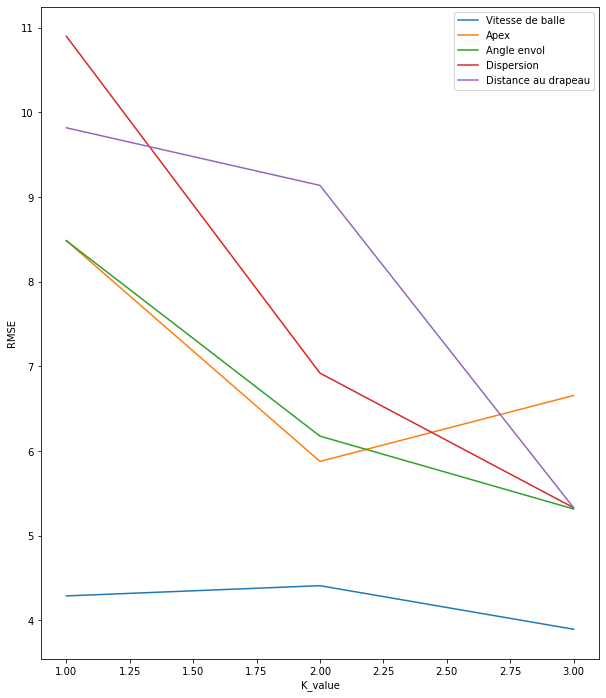

In [100]:
best_features = {}
plt.figure(figsize=(10, 12))

for key, value in feature_k_rmse_results.items():
    x = list(value.keys())
    y = list(value.values())
    
    order = np.argsort(x)
    x_ordered = np.array(x)[order]
    y_ordered = np.array(y)[order]
    print(key)
    print('average_rmse: '+str(np.mean(y)))
    best_features[key] = np.mean(y)

    plt.plot(x_ordered, y_ordered, label=key)
    plt.xlabel("K_value")
    plt.ylabel("RMSE")
plt.legend()
plt.show()

In [101]:
sorted_features_list = sorted(best_features, key=best_features.get)
sorted_features_list

['Vitesse de balle',
 'Angle envol',
 'Apex',
 'Dispersion',
 'Distance au drapeau']

## Modèle multivarié

In [102]:
def knn_train_test3(train_cols, target_col, df):
    np.random.seed(0)
    
    # Randomise l'ordre des lignes du DataFrame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    # Diviser le nombre de lignes de moitié.
    last_train_row = int(len(rand_df) / 2)
    
    # Sélectionner la première moitié pour le set de training.
    # Sélectionner la seconde moitié pour le set de test.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [3]
    k_rmses = {}
    
    for k in k_values:
        # Ajuster le modèle en utilisant la valeur k.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])
        
        # Faire des prédictions en utilisant le modèle.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculer et retourner la valeur RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
        
    return k_rmses

In [103]:
k_rmse_features ={}

best_two_features = sorted_features_list[0:2]
best_three_features = sorted_features_list[0:3]
best_four_features = sorted_features_list[0:4]

k_rmse_features["best_two_rmse"]  = knn_train_test3(best_two_features, 'Portee', golf)
k_rmse_features["best_three_rmse"] = knn_train_test3(best_three_features, 'Portee', golf)
k_rmse_features["best_four_rmse"] = knn_train_test3(best_four_features, 'Portee', golf)

k_rmse_features

{'best_two_rmse': {3: 5.316640543300504},
 'best_three_rmse': {3: 4.860269768461648},
 'best_four_rmse': {3: 6.656659155395533}}

## Variation des hyper paramètres

In [104]:
def knn_train_test4(train_cols, target_col, df):
    np.random.seed(0)
    
    # Randomise l'ordre des lignes du DataFrame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    # Diviser le nombre de lignes de moitié.
    last_train_row = int(len(rand_df) / 2)
    
    # Sélectionner la première moitié pour le set de training.
    # Sélectionner la seconde moitié pour le set de test.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [i for i in range(1, 3)]
    k_rmses = {}
    
    for k in k_values:
        # Ajuster le modèle en utilisant la valeur k.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])
        
        # Faire des prédictions en utilisant le modèle.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculer et retourner la valeur RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
        
    return k_rmses

In [105]:
features = [best_two_features, best_three_features]
k_rmse_results = {}
k_rmse_results["best_two_features"] = knn_train_test4(best_two_features, 'Portee', golf)
k_rmse_results["best_three_features"] = knn_train_test4(best_three_features, 'Portee', golf)

k_rmse_results

{'best_two_features': {1: 4.2895221179054435, 2: 4.410215414239989},
 'best_three_features': {1: 4.381780460041329, 2: 4.410215414239989}}

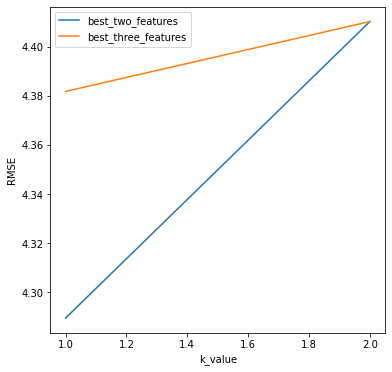

In [106]:
plt.figure(figsize=(6, 6))

for key, value in k_rmse_results.items():
    
    x = list(value.keys())
    y = list(value.values())
    plt.plot(x, y, label=key)
    plt.xlabel("k_value")
    plt.ylabel("RMSE")
    
plt.legend()
plt.show()

# Quel fer faut-il jouer pour une distance au drapeau donné par son télémètre ou montre GPS

# Distance et fer tapé au practice

In [2845]:
import pandas as pd
import numpy as np
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import seaborn as sb
from itertools import cycle
import sys

In [2919]:
def read_csv_data(file,delimiter):

    cols = ["Carry distance mts","Total distance","Club","Ball speed km/h","Apex","Launch angle","Dispersion","Distance to flag"]
    df = pd.read_csv(file,delimiter=delimiter, names=cols)
    
    df = df.drop(df.index[0])
    
    #print(df.head(20))
    #print(df.describe())
    
    return df


In [2920]:
def transform_features(df,golf_club_number=3):

    stripped_commas_1 = df["Carry distance mts"].str.replace(",",".")
    df["Carry distance mts"] = stripped_commas_1.astype('float')
    
    stripped_commas_2 = df["Ball speed km/h"].str.replace(",",".")
    df["Ball speed km/h"] = stripped_commas_2.astype('float')
    
    stripped_commas_3 = df["Apex"].str.replace(",",".")
    df["Apex"] = stripped_commas_3.astype('float')
    
    stripped_commas_4 = df["Launch angle"].str.replace(",",".")
    df["Launch angle"] = stripped_commas_4.astype('float')

    stripped_commas_5 = df["Dispersion"].str.replace(",",".")
    df["Dispersion"] = stripped_commas_5.astype('float')

    stripped_commas_6 = df["Distance to flag"].str.replace(",",".")
    df["Distance to flag"] = stripped_commas_6.astype('float')

    stripped_commas_7 = df["Club"].str.replace(",",".")
    df["Club"] = stripped_commas_7.astype('int')
         
    #Club Choice
    df = df[df["Club"] == golf_club_number]

    #caractéristiques non utiles au modèle
    del df["Total distance"]
    del df["Distance to flag"]
    del df["Club"]
   
    #print(df)

    return df

In [2935]:
def describe_data(df):
    
    
    cols = ["Carry distance mts","Ball speed km/h","Apex","Launch angle","Dispersion"]
    dict_data = {}
    
    for col in cols:
        mean = df[[col]].mean()
        maxi = df[[col]].max()
        dict_data[col] = {"mean":mean, "max":maxi}

    #df = pd.DataFrame(dict_data)
    #print(df)  
    
    return dict_data

In [2941]:
def select_features(df, coeff_corr=0.1):
    
    #print(df.head())
    #print(df.info())
    
    #selection des caractéristiques numériques et on étudie leur correlation avec Portee
    df = df.select_dtypes(include=["int","float"])
    abs_corr_coeffs = df[list(df.columns.values)].corr().abs()
    
    #print(abs_corr_coeffs)
    
    #trace de la heatmap
    sb.heatmap(abs_corr_coeffs)
    
    #classe les valeurs de correlaction de la colonne Portee
    abs_corr_coeffs_sorted = df[list(df.columns.values)].corr()["Carry distance mts"].abs().sort_values()
    
    abs_corr_coeffs_sorted[abs_corr_coeffs_sorted > coeff_corr]
    
    #Suppression des colonnes avec coeff de corrélation inférieur de 0.4 avec Portee
    transform_df = df.drop(abs_corr_coeffs_sorted[abs_corr_coeffs_sorted < coeff_corr].index, axis=1)
    transform_df.shape[1]

    #print(transform_df.head())
    
    return transform_df

In [2942]:
colors = iter(['xkcd:deep blue', 'xkcd:dusky purple', 'xkcd:melon','xkcd:moss green'])
    
def my_scatter(x,y, **kwargs):
    kwargs['color'] = next(colors)
    plt.scatter(x,y, **kwargs)
    
    
def draw_data(df,golf_club_number=3):
    
    #Distance with club
    str_golf_club_number = str(golf_club_number)
    fig = plt.figure()
    plt.scatter(df.index,df["Carry distance mts"])
    plt.title("Golf ball carry distance with club n°"+ str_golf_club_number, fontsize=16)
    plt.xlabel("Golf ball shots", fontsize=13)
    plt.ylabel("Golf ball carry distance mts", fontsize=13)
    ax = plt.axes()
    ax.set_facecolor('#FFFFFF')
    #fig.patch.set_facecolor('black')
    #plt.style.use("bmh")
    #plt.rcParams.update({"figure.figsize" : (12, 8),
    #                 "axes.facecolor" : "white",
    #                 "axes.edgecolor":  "black"})
    plt.show()
    
    
    #Dataframe PGA and concat with Dataframe of User data
    pga_columns = ["Carry distance mts PGA","Ball speed km/h PGA","Apex PGA","Launch angle PGA","Dispersion PGA"]
    pga_data = { "Carry distance mts PGA" :[281],
                 "Ball speed km/h PGA":[273],
                 "Apex PGA":[31],                
                 "Launch angle PGA":[10.84],  
                 "Dispersion PGA":[0]
               }
    df_pga = pd.DataFrame(pga_data, columns = pga_columns)    
    df_with_pga = pd.concat([df, df_pga], ignore_index = True)
    
    #Dataframe Mean of data User and data PGA witth around values
    df_with_pga_mean = df_with_pga.mean(axis = 0, skipna = True).apply(np.ceil)
 
    #Dataframe from Mean rebuild for plot
    user_and_pga_mean_data = {
        "User data":[df_with_pga_mean["Carry distance mts"],df_with_pga_mean["Ball speed km/h"],df_with_pga_mean["Apex"],df_with_pga_mean["Launch angle"]],
        "PGA data":[df_with_pga_mean["Carry distance mts PGA"],df_with_pga_mean["Ball speed km/h PGA"],df_with_pga_mean["Apex PGA"],df_with_pga_mean["Launch angle PGA"]]
    }
    df_user_and_pga_mean = pd.DataFrame(user_and_pga_mean_data,index=['Ball carry distance', 'Ball speed (km/h)','Ball apex','Ball Launch angle'])
    #Convert to int for histogram
    df_user_and_pga_mean["User data"] = df_user_and_pga_mean["User data"].astype(int)
    df_user_and_pga_mean["PGA data"] = df_user_and_pga_mean["PGA data"].astype(int)
    

    #Compare each features ball on golf ball carry distance    
    pairgrid = sb.pairplot(df, x_vars=['Ball speed km/h','Apex','Launch angle','Dispersion'], y_vars='Carry distance mts', height=3, aspect=0.9,kind="reg")
    
    #change color for each grid
    pairgrid.map_offdiag(my_scatter)
    
    #Title    
    plt.subplots_adjust(top=0.9)
    pairgrid.fig.suptitle('Carry distance compared to golf ball features')
    
    plt.show()
    
    
    #Second Plot Bar of average data compared to PGA
    fig = plt.figure(figsize=(20,8))
        
    ax = df_user_and_pga_mean.plot(kind='bar',color=['#017dc3', '#063c6e'])
    
    #display number on bar
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    
    plt.title("Compare your data with PGA players on golf ball", fontsize=16)
    plt.xlabel("", fontsize=13)
    plt.ylabel("Average", fontsize=13)
    
    
    plt.legend()        
    
    plt.show()
    

In [2943]:
def train_and_test(df, k=0):
    
    numeric_train = df.select_dtypes(include=["integer","float"])
    numeric_test  = df.select_dtypes(include=["integer","float"])
    
    lr = linear_model.LinearRegression()
    
    split_train_test_value = np.around((len(df) / 2)).astype('int32')
    #split_train_test_value = 2
    #print(split_train_test_value)
    
    if k == 0:
        
        train = df.iloc[0:split_train_test_value] 
        test  = df.iloc[split_train_test_value:]
        
        #add column to categorize train and test
        train.insert(0, "Type of data", "Training", True)
        test.insert(0, "Type of data", "Testing", True)
        
        #train_cat = train.set_index('Train')
        #test_cat = test.set_index('Test')
        
        train_test_df = pd.concat([train, test]) 
        #train_test_df.index.names=["DataType"]
        #print(train_test_df)
        
        #Draw plot of train data vs test data  
        pairgrid = sb.pairplot(train_test_df, x_vars=['Ball speed km/h','Apex','Launch angle','Dispersion'], y_vars='Carry distance mts', height=3, aspect=0.6,hue="Type of data")   
        pairgrid.map(sb.kdeplot)
        plt.subplots_adjust(top=0.9)
        pairgrid.fig.suptitle('Comparison of train and test data on golf ball carry distance regarding Ball features')
        plt.show()
        
    
        features = numeric_train.columns.drop("Carry distance mts")
    
        #Entrainement
        res = lr.fit(train[features],train["Carry distance mts"])

        #Impression de la pente entre chaque feature et la feature Portee
        #2.04% de Portee en plus pour 1km/h de vitesse de balle en plus
        improve_pourcent_array = lr.coef_        
        for idx, col_name in enumerate(train[features].columns):
            print("A unit increase in {} is associated with {} unit in increase Ball distance".format(col_name, lr.coef_[idx]))
        
        #print(lr.intercept_)

        
        coeff = pd.DataFrame([improve_pourcent_array], columns=features)
        #print(lr.coef_)
        #print(coeff.head())
        
        #Prediction sur la série des données de test
        predicted_model = lr.predict(test[features])
        
        #Add predicted values to test dataframe
        test.insert(2, "Predicted Carry distance mts", predicted_model) 
        
        df_check = pd.DataFrame({'Carry distance on testing data':test['Carry distance mts'],'Carry distance predicted':test['Predicted Carry distance mts']})
        #print(df_check)

        #Draw plot of test data on predict data         
        df_check.reset_index(drop='True').plot()
        x_scale_limit = df_check.index.max() / 2
        plt.xlim(1, np.abs(x_scale_limit))
        plt.title("Comparison of Golf ball carry on testing data and Golf ball carry on predicted data", fontsize=16)
        plt.ylabel("Ball carry mts", fontsize=13)
        plt.xlabel("Club shots", fontsize=13)
        plt.show()
        
              
        #Draw plot of test data on predict data              
        pairgrid = sb.pairplot(test, x_vars=['Ball speed km/h','Apex','Launch angle','Dispersion'], y_vars='Predicted Carry distance mts', height=3, aspect=0.6)   
        #pairgrid.map(sb.kdeplot)
        plt.subplots_adjust(top=0.9)
        pairgrid.fig.suptitle('Comparison of predicted ball carry distance regarding testing data ball features')
        plt.show()

               
        #Calcul de l'erreur quadratique moyenne
        test_mse = mean_squared_error(test["Predicted Carry distance mts"], test["Carry distance mts"])    
        test_rmse = np.sqrt(test_mse) 
        
        #coefficient of determination
        score_model = lr.score(test[features],test["Carry distance mts"])
        
        #variance of model
        #standard_deviation_model = np.std(score_model)
        
        #in our model, 82.85% of the variability in Y can be explained using X
        print("score_model R-squared coeff of determination:", score_model)  
        #print("standard deviation model:", standard_deviation_model)
        print("Error of test data on prediction of ball carry distance mts:",test_rmse)
        #So we are an average of 5.86 meters of "carry distance of ball" away 
        #from the ground truth "carry distance" when making predictions on our test set.
        print("Mean of Carry distance mts:", df["Carry distance mts"].mean())
        #doofinder
    
    return lr

In [2944]:
def predict_distance(model, df):
        
    carry_distance_predicted = model.predict(df)    
    #print(carry_distance_predicted)        
    
    df["Predicted Carry distance mts"] = carry_distance_predicted
    
    print(df)
    
    
    
    #Draw plot of test data on predict data              
    pairgrid = sb.pairplot( df, y_vars='Predicted Carry distance mts', x_vars=['Ball speed km/h','Apex','Launch angle','Dispersion'], height=3, aspect=0.6)   
    pairgrid.map(plt.hist, color = 'darkred')
    plt.subplots_adjust(top=0.9)
    pairgrid.fig.suptitle('Comparison of predicted ball carry distance regarding your data ball features')
    plt.show()    
    
    
    return carry_distance_predicted

<ipython-input-2942-1aaf6e0b5f3c>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


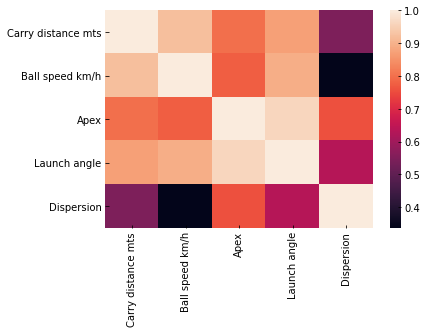

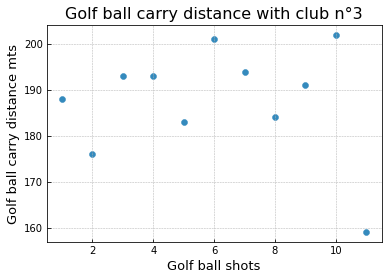

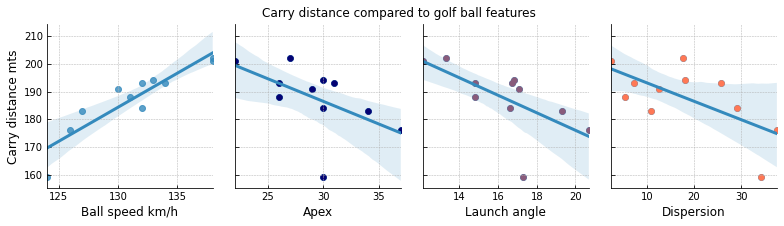

<Figure size 1440x576 with 0 Axes>

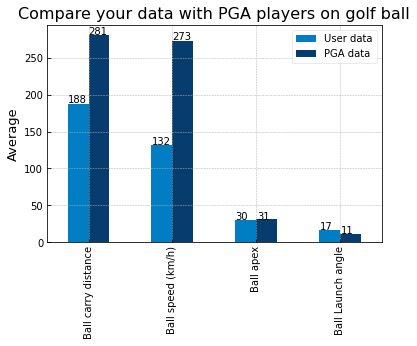

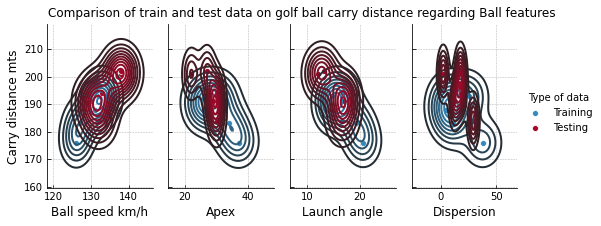

A unit increase in Ball speed km/h is associated with 5.146043480984885 unit in increase Ball distance
A unit increase in Apex is associated with -9.717436250861414 unit in increase Ball distance
A unit increase in Launch angle is associated with 20.825136269657158 unit in increase Ball distance
A unit increase in Dispersion is associated with -0.06954451475471224 unit in increase Ball distance


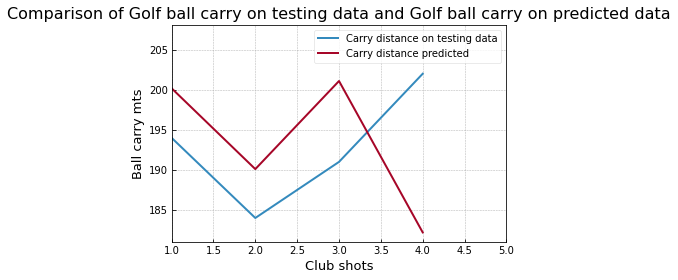

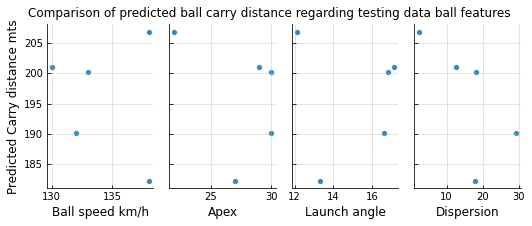

score_model R-squared coeff of determination: -1.7296699490274476
Error of test data on prediction of ball carry distance mts: 10.989112727830863
Mean of Carry distance mts: 190.5
   Ball speed km/h  Apex  Launch angle  Dispersion  \
0              131    26          14.8         5.3   

   Predicted Carry distance mts  
0                         188.0  


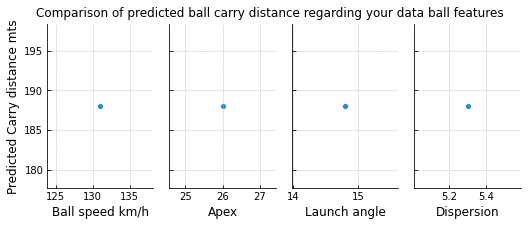

Ball distance carry predicted is: [188.]  meters


In [2945]:
df = read_csv_data('golf-data.csv',',')

golf_club_number = 3

transform_df = transform_features(df, golf_club_number)
#describe_data(transform_df)

coeff_corr = 0.5
filtered_df = select_features(transform_df, coeff_corr)
draw_data(df,golf_club_number)

lr = train_and_test(filtered_df, k=0)

df_to_predict = pd.DataFrame({"Ball speed km/h":[131], "Apex":[26], "Launch angle":[14.8], "Dispersion":[5.3]})
predicted_carry_distance = predict_distance(lr,df_to_predict)
print("Ball distance carry predicted is:",predicted_carry_distance," meters")
